In [1]:
# Initial imports
import pandas as pd
from path import Path
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
from sqlalchemy.orm import scoped_session, sessionmaker
engine = create_engine("postgresql://postgres:V@ndy2021BootC@mp@localhost:5432/postgres")

In [2]:
# retrieve data from PostGres and put into dataframes
ratings_df=pd.read_sql('SELECT * FROM ratings',engine)
ratings_df.head()

,userid,movieid,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [3]:
genometags_df=pd.read_sql('SELECT * FROM genome_tags',engine)
genometags_df.head()

,tagid,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [4]:
genomescores_df=pd.read_sql('SELECT * FROM genome_scores',engine)
genomescores_df.head()

,movieid,tagid,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [5]:
movies_df=pd.read_sql('SELECT * FROM movies',engine)
movies_df.head()

,movieid,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# We see that there are ~62k movies in this dataframe.  
movies_df.movieid.count()

62423

In [8]:
# This dataframe is rather large since it has tagIds and the relevant match each original 62k movies in the dataset
genomescores_df.shape

(15584448, 3)

In [10]:
# Now lets combine the list of movies with their genome scoring as a dataframe
df=pd.merge(movies_df,genomescores_df,on='movieid', how='left')
df.head()

,movieid,title,genres,tagid,relevance
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,0.02875
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,0.02375
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,0.06250
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0,0.07575
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,0.14075


In [11]:
# check the size of our new dataframe
df.shape

(15633055, 5)

In [13]:
# pivot the table to have movieIds as rows and genome tags as cols with relevance as values
X=df.pivot(index='movieid',columns='tagid',values='relevance')

In [14]:
X.drop(X.columns[0],axis=1,inplace=True)
X.head()

tagid,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1119.0,1120.0,1121.0,1122.0,1123.0,1124.0,1125.0,1126.0,1127.0,1128.0
movieid,,,,,,,,,,,,,,,,,,,,,
1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,0.03075,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,0.05250,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,0.03875,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,0.03150,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,0.02975,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


In [15]:
X.dropna(inplace=True)

In [16]:
X.describe

<bound method NDFrame.describe of tagid     1.0      2.0      3.0      4.0      5.0      6.0      7.0     \
movieid                                                                  
1        0.02875  0.02375  0.06250  0.07575  0.14075  0.14675  0.06350   
2        0.04125  0.04050  0.06275  0.08275  0.09100  0.06125  0.06925   
3        0.04675  0.05550  0.02925  0.08700  0.04750  0.04775  0.04600   
4        0.03425  0.03800  0.04050  0.03100  0.06500  0.03575  0.02900   
5        0.04300  0.05325  0.03800  0.04100  0.05400  0.06725  0.02775   
...          ...      ...      ...      ...      ...      ...      ...   
205072   0.02050  0.01775  0.11400  0.03650  0.31225  0.03675  0.10700   
205076   0.03825  0.03150  0.03200  0.05325  0.20850  0.07050  0.06625   
205383   0.04100  0.04025  0.02750  0.07850  0.19750  0.17825  0.17125   
205425   0.04525  0.04125  0.04250  0.07425  0.11550  0.10500  0.08275   
206499   0.10050  0.09325  0.02225  0.04550  0.21125  0.06125  0.10425   

tag

In [17]:
X_scaled=StandardScaler().fit_transform(X)

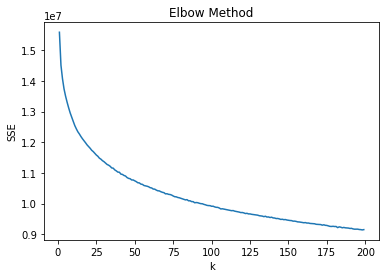

In [18]:
sse = {}
K = range(1,200)
for k in K:
    kmeanmodel = KMeans(n_clusters=k).fit(X_scaled)
    sse[k]= kmeanmodel.inertia_
    
# Plot
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [20]:
# Create a KMeans model with 200 clusters
model = KMeans(n_clusters=200, random_state=42).fit(X_scaled)

In [21]:
# Calculate predicted values.
y_pred = model.predict(X_scaled)

In [22]:
y_pred

array([146, 107,  50, ...,  20, 184,  18])

In [23]:
# Add predicted values onto the original dataframe
df_y = pd.DataFrame(y_pred, columns=['Cluster'])
combined = X.join(df_y, how='inner')
combined.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1120.0,1121.0,1122.0,1123.0,1124.0,1125.0,1126.0,1127.0,1128.0,Cluster
1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,0.03075,...,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200,107
2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,0.05250,...,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975,50
3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,0.03875,...,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775,41
4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,0.03150,...,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500,41
5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,0.02975,...,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600,136


In [24]:
combined.to_csv('clustercheck.csv')